<a href="https://colab.research.google.com/github/tewarikhush/agent-image-generation/blob/main/VisualAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install SAM
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Install other necessary packages
!pip install opencv-python numpy scikit-learn matplotlib

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fm0cbjka
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fm0cbjka
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=dde7a2d2034bed46429a417e8f36b4c266b475698714dd3ac7307d6c442f933d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9aombc5r/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [ ]:
# Download the SAM model checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-11-12 21:48:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.118, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   268MB/s    in 15s     

2025-11-12 21:48:26 (168 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import torch
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- ⚠️ IMPORTANT: Change this path to your file location on Google Drive ---
# image_path = '/content/drive/MyDrive/image36-1.png'
# image_path = '/content/drive/MyDrive/WhatsApp Image 2025-11-04 at 18.36.23_cf943bf9.jpg'
image_path = '/content/drive/MyDrive/WhatsApp Image 2025-11-04 at 18.37.24_9bd71e93.jpg'
# Example: '/content/drive/MyDrive/MyProject/data/target_image.png'

# Load the image using OpenCV
image_bgr = cv2.imread(image_path)

# Check if the image loaded successfully
if image_bgr is None:
    raise FileNotFoundError(f"Error: Image not found at {image_path}. Check your path!")

# Convert the image from BGR (OpenCV's default) to RGB (SAM's and Matplotlib's requirement)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print(f"Image successfully loaded from Drive. Shape: {image_rgb.shape}")

# 2. Set up SAM
model_type = "vit_h"  # or "vit_l", "vit_b"
checkpoint_path = "sam_vit_h_4b8939.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)

# Use SamAutomaticMaskGenerator for all elements
mask_generator = SamAutomaticMaskGenerator(sam)

# 3. Generate all masks
sam_results = mask_generator.generate(image_rgb)

# sam_results is a list of dictionaries, where each dict contains 'segmentation' (the boolean mask)
# and 'area' (of the mask in pixels)

Image successfully loaded from Drive. Shape: (480, 720, 3)


In [ ]:
# Assuming 'sam_results' is the output from mask_generator.generate(image_rgb)

# 1. Print a Summary
print(f"Total number of objects (masks) found: **{len(sam_results)}**")

# 2. Inspect the Keys of a Single Result
if sam_results:
    first_result = sam_results[0]
    print("\n--- Keys in the first result dictionary ---")
    print(first_result.keys())

    # 3. Print the Measurable Boundaries and Mask shape for the first object
    print("\n--- Details of the First Object (Mask) ---")

    # Bounding Box: [x, y, width, height]
    print(f"Bounding Box (x, y, w, h): **{first_result.get('bbox')}**")

    # Area (in pixels)
    print(f"Area (pixels): **{first_result.get('area')}**")

    # Segmentation (the mask itself)
    # This is a large NumPy array, so we only print its shape and type
    segmentation_mask = first_result.get('segmentation')
    print(f"Segmentation Mask shape: **{segmentation_mask.shape}**")
    print(f"Segmentation Mask data type: {segmentation_mask.dtype}")

    # Point coordinates (if available, depends on SAM version/settings)
    print(f"Point coordinates (raw): {first_result.get('point_coords')}")

# Example Output structure:
# Total number of objects (masks) found: 15
#
# --- Keys in the first result dictionary ---
# dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
#
# --- Details of the First Object (Mask) ---
# Bounding Box (x, y, w, h): [200, 150, 45, 60]
# Area (pixels): 2500
# Segmentation Mask shape: (680, 1024)
# Segmentation Mask data type: bool
# Point coordinates (raw): [[220, 180]]

Total number of objects (masks) found: **65**

--- Keys in the first result dictionary ---
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

--- Details of the First Object (Mask) ---
Bounding Box (x, y, w, h): **[93, 58, 186, 153]**
Area (pixels): **21364**
Segmentation Mask shape: **(480, 720)**
Segmentation Mask data type: bool
Point coordinates (raw): [[146.25, 202.5]]


In [ ]:
from sklearn.cluster import KMeans
from matplotlib import colors as mcolors

def get_dominant_color(image_rgb, mask, n_colors=3):
    """
    Applies K-Means clustering to find the dominant colors
    within the area defined by the mask.
    """
    # 1. Extract pixels within the mask
    # The mask is a boolean array (W, H). We use it to index the image array (W, H, 3).
    # This gives us an (N, 3) array where N is the number of pixels in the mask.
    masked_pixels = image_rgb[mask]

    if masked_pixels.shape[0] < n_colors:
        # Not enough pixels to form the requested number of clusters
        return None

    # 2. Run K-Means Clustering
    # You could also use cv2.kmeans for more fine-grained control
    try:
        kmeans = KMeans(n_clusters=n_colors, random_state=0, n_init=10)
        kmeans.fit(masked_pixels)

        # 3. Get the dominant color(s) (cluster centers)
        # Centers are in RGB format (0-255)
        dominant_colors_rgb = kmeans.cluster_centers_.astype(int)

        # To find the most dominant color, you can look at the size of the clusters
        # The labels indicate which cluster each pixel belongs to
        labels = kmeans.labels_

        # Count the number of pixels in each cluster
        counts = np.bincount(labels)

        # The most frequent color is the one from the largest cluster
        most_frequent_cluster_index = np.argmax(counts)
        most_dominant_color = dominant_colors_rgb[most_frequent_cluster_index]

        return most_dominant_color, counts, dominant_colors_rgb

    except ValueError as e:
        print(f"K-Means failed for a mask: {e}")
        return None

# 4. Iterate through all SAM masks and analyze color
analyzed_objects = []
for result in sam_results:
    mask = result['segmentation']
    area = result['area']
    bbox = result['bbox'] # [x, y, w, h] - for boundary info

    color_result = get_dominant_color(image_rgb, mask, n_colors=3)

    if color_result is not None:
        dominant_color_rgb, counts, all_colors = color_result

        analyzed_objects.append({
            'area': area,
            'bbox_xywh': bbox,
            'mask': mask,
            'dominant_color_rgb': dominant_color_rgb.tolist(),
            'all_dominant_colors_rgb': all_colors.tolist(),
            # Add more metrics as needed
        })
    else:
        analyzed_objects.append({
            'area': area,
            'bbox_xywh': bbox,
            'mask': mask,
            'note': 'Skipped color analysis: too few pixels in mask'
        })

print(f"Found and analyzed {len(analyzed_objects)} objects.")

Found and analyzed 65 objects.


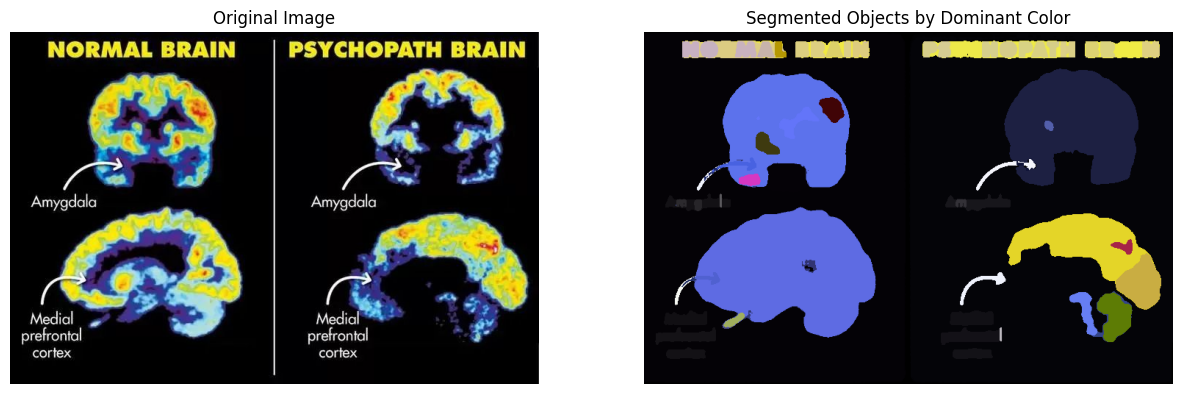


--- MEASURABLE BOUNDARY & COLOR SUMMARY ---
Object 1:
  Area: 21364 px²
  Size: 186x153 px
  Color: #2b3975
--------------------
Object 2:
  Area: 168784 px²
  Size: 355x475 px
  Color: #020103
--------------------
Object 3:
  Area: 168312 px²
  Size: 357x475 px
  Color: #020204
--------------------
Object 4:
  Area: 170180 px²
  Size: 639x477 px
  Color: #020204
--------------------
Object 5:
  Area: 29959 px²
  Size: 245x176 px
  Color: #2d326c
--------------------
Object 6:
  Area: 169397 px²
  Size: 584x475 px
  Color: #020103
--------------------
Object 7:
  Area: 383 px²
  Size: 18x21 px
  Color: #ede72c
--------------------
Object 8:
  Area: 2949 px²
  Size: 61x76 px
  Color: #e5d81a
--------------------
Object 9:
  Area: 546 px²
  Size: 28x21 px
  Color: #ede63c
--------------------
Object 10:
  Area: 390 px²
  Size: 18x21 px
  Color: #ece63d
--------------------
Object 11:
  Area: 365 px²
  Size: 23x21 px
  Color: #ebe729
--------------------
Object 12:
  Area: 455 px²
  Size

In [ ]:
import matplotlib.pyplot as plt

def visualize_analysis(image_rgb, analyzed_objects):
    """
    Displays the original image alongside the segmented objects,
    colored by their dominant K-Means color.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Display Original Image
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Prepare an overlay image for all segments
    # Use a black background (0, 0, 0)
    composite_mask_image = np.zeros_like(image_rgb, dtype=np.uint8)

    # Prepare text for area/size summary
    summary_text = ""

    for i, obj in enumerate(analyzed_objects):
        mask = obj['mask']
        area = obj['area']
        bbox = obj['bbox_xywh']

        # Calculate the size (width x height) from the bounding box
        width = bbox[2]
        height = bbox[3]
        size_str = f"{width}x{height} px"

        if 'dominant_color_rgb' in obj:
            # The dominant color calculated by K-Means
            color_rgb = np.array(obj['dominant_color_rgb'], dtype=np.uint8)

            # Create a 3-channel (R, G, B) image for the current mask
            # This broadcast the color across all pixels within the mask
            colored_segment = np.zeros_like(image_rgb, dtype=np.uint8)
            colored_segment[mask] = color_rgb

            # Add the colored segment to the composite image
            composite_mask_image += colored_segment

            # Format the color as a hex string for display purposes
            hex_color = '#%02x%02x%02x' % tuple(color_rgb)
            color_str = f"Color: {hex_color}"

        else:
            # Handle cases where color analysis was skipped
            color_str = "Color: N/A"

        # Append metrics to the summary text
        summary_text += (
            f"Object {i+1}:\n"
            f"  Area: {area} px²\n"
            f"  Size: {size_str}\n"
            f"  {color_str}\n"
            "--------------------\n"
        )

    # Display the composite mask image
    axes[1].imshow(composite_mask_image)
    axes[1].set_title("Segmented Objects by Dominant Color")
    axes[1].axis('off')

    # Display the combined plot
    plt.show()

    # Print the detailed text summary
    print("\n--- MEASURABLE BOUNDARY & COLOR SUMMARY ---")
    print(summary_text)

# --- EXECUTE THE VISUALIZATION ---
# NOTE: This assumes 'image_rgb' and 'analyzed_objects' are ready from Steps 1-3.
visualize_analysis(image_rgb, analyzed_objects)